<a href="https://colab.research.google.com/github/AstridZhao/Spring2023DeepLearning/blob/main/Deep_learning_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows you how to model sequential data with Long Short-Term Memory (LSTM) model to predict sentiment scores.

# Data acquisition

In [1]:
!pip install pytreebank
import pytreebank
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pytreebank: filename=pytreebank-0.2.7-py3-none-any.whl size=37071 sha256=6ed5f0a77eec0691b17d62ca3cbde722e162825fe56368b1fb7ff3a672f86411
  Stored in directory: /root/.cache/pip/wheels/e4/11/43/7a30d0573bacddb9b5d0ff33a9c9c8f61d19384e6da8ed2888
Successfully built pytreebank


In [2]:
# Load the dataset from disk
dataset = pytreebank.load_sst("/path/to/sentiment/")

train_data = dataset['train']

In [3]:
# Example sentence data and sentiment ratings
sentences = []
sentiment_ratings = []

for tree in train_data:
  datapoint = tree.to_labeled_lines()[0]
  sentiment_ratings.append(datapoint[0])
  sentences.append(datapoint[1])

Now map the vocabulary learned by the tokenizer. Convert each vocabulary to a number which model could use for training.

In [4]:
# Tokenize sentences and convert sentiment ratings to categorical labels
num_words = 10000
tokenizer = Tokenizer(num_words,lower=True)
tokenizer.fit_on_texts(sentences)

In [5]:
sequences = tokenizer.texts_to_sequences(sentences) # this converts texts into some numeric sequences
#word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])

sequences_padding = pad_sequences(sequences, padding='post', maxlen=max_sequence_length) # this makes the length of all numeric sequences equal
labels = to_categorical(sentiment_ratings)

In [6]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(sequences_padding, labels, test_size=0.2, random_state=0)
test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=0)

In [8]:
print(train_data.shape, train_labels.shape)
print(val_data.shape,val_labels.shape)
print(test_data.shape,test_labels.shape)

(6835, 48) (6835, 5)
(855, 48) (855, 5)
(854, 48) (854, 5)


# Training with additional Embeddings and LSTM


We tried to use Word2Vec, which is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets. However, it does not work desirable.

Reference: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/


We are going to use glove-wiki-gigaword-300 which is trained on data and maps a word into an array of length 300. we also have glove-wiki-gigaword-300 which gives a better result but it’s computationally heavy because of higher dimension.

Loading the pertained glove vector using the gensim library.

In [9]:
!pip install gensim
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300') #More dimension means more deep meaning of words but it may take a longer time to download.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[=================================================-] 98.6% 370.8/376.1MB downloaded


Now create a weight matrix.

In [10]:
vector_size = 300
num_words = 50000
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

# tokenizer.word_index.items() returns a dictionary of unique words as key and frequency as value.
# If a word is found in glove vocabulary then return the corresponding vector and append it in gensim_weight_matrix.
# gensim_weight_matrix must have the size of (number of unique words, glove_dimension).

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(300)

Embedding Layer: we already have created a word-embedding matrix. to feed our word_embedding matrix in our training we would use an embedding layer.

There are 3 parameters in embedding layers.

input_dim : Vocabulary Size( number of unique words for training)

output_dim : Length of the vector for each word(embedding dimension)

input_length : Maximum length of a sequence

trainable : It’s False, which means it will only use a given weight matrix,

In [33]:
EMBEDDING_DIM = 300

embedding_layer = Embedding(input_dim = num_words,
        output_dim = EMBEDDING_DIM,
        input_length= train_data.shape[1],
        weights=[gensim_weight_matrix],
        trainable=False,
        )

In [39]:
class_num = 5

# Define the model
model = Sequential()
model.add(embedding_layer)
# LSTM Layer
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid', dropout=0.2))
# Dropout layer
model.add(Dropout(0.4))
# Dense layers
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(class_num, activation = 'softmax'))

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 48, 300)           15000000  
                                                                 
 lstm_3 (LSTM)               (None, 128)               219648    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)              

In order to train efficiently, we defined some callbacks: EarlyStopping and ModelCheckpoint


*   EarlyStopping stops the training after some patience if no further improvement is observed or if training loss decreases and validation loss increases after a certain point.
*   ModelChckpoint saves the model checkpoint.



In [41]:
# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping, ModelCheckpoint

mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


history_embedding keeps the history of model training.

In [42]:
model.fit(train_data, train_labels, validation_data = (val_data, val_labels), epochs=1000, batch_size=32, callbacks=[es,mc])

Epoch 1/1000
214/214 [==============================] - ETA: 0s - loss: 1.5773 - accuracy: 0.2695
Epoch 1: val_accuracy improved from -inf to 0.28538, saving model to ./model.h5
214/214 [==============================] - 42s 132ms/step - loss: 1.5773 - accuracy: 0.2695 - val_loss: 1.5541 - val_accuracy: 0.2854
Epoch 2/1000
214/214 [==============================] - ETA: 0s - loss: 1.5724 - accuracy: 0.2739
Epoch 2: val_accuracy did not improve from 0.28538
214/214 [==============================] - 27s 125ms/step - loss: 1.5724 - accuracy: 0.2739 - val_loss: 1.5491 - val_accuracy: 0.2854
Epoch 3/1000
214/214 [==============================] - ETA: 0s - loss: 1.5471 - accuracy: 0.3024
Epoch 3: val_accuracy improved from 0.28538 to 0.38596, saving model to ./model.h5
214/214 [==============================] - 27s 128ms/step - loss: 1.5471 - accuracy: 0.3024 - val_loss: 1.4522 - val_accuracy: 0.3860
Epoch 4/1000
214/214 [==============================] - ETA: 0s - loss: 1.4153 - accuracy:

# Plot Evaluation


We have prepared X_test_pad for testing purposes, it's time to test on it.

> np.argmax returns the index of maximum probability.


In [44]:
# Evaluate the model
loss, val_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy: {:.2f}%".format(val_accuracy * 100))

27/27 [==============================] - 2s 72ms/step - loss: 1.7061 - accuracy: 0.4016
Test Accuracy: 40.16%


27/27 [==============================] - 2s 51ms/step


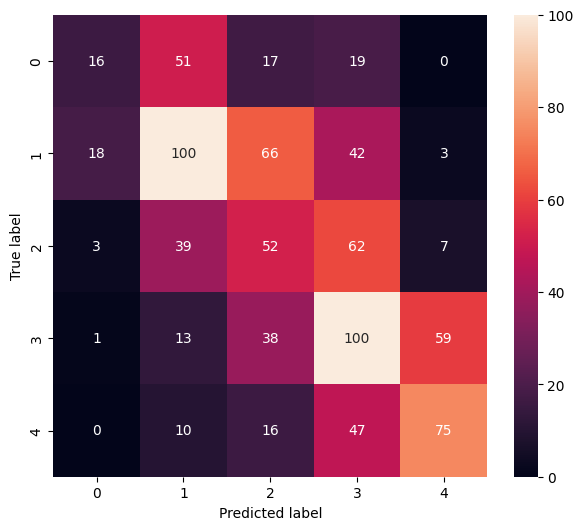

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the confusion matrix
preds = model.predict(test_data)
conf = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(preds, axis=1))

# plot the confusion matrix as a heatmap
plt.figure(figsize=(7,6))
sns.heatmap(conf, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()